# HOUSE SALES IN KING COUNTY, USA

- **COMPANY:** House Rocket.


- **BUSINESS MODEL:** Buy houses at a low price and review at the highest price.


- **WHAT'S THE CHALLENGE:** Finding good deals within the available portfolio, that is, finding homes with a low price, in a great location and that have a great resale potential for a higher price.


- **DATA:** This dataset contains house sale prices for King County, which includes Seattle. It includes homes sold between May 2014 and May 2015.


- **SOURCE:** https://www.kaggle.com/harlfoxem/housesalesprediction




# 0.0 SETUP

## 0.1 Imports

In [1]:
# Data Manipulation
import csv
import random
import datetime
import numpy               as np
import pandas              as pd

# Exploratory Data Analyses
import seaborn             as sns
import plotly.express      as px
import matplotlib.pyplot   as plt
#import matplotlib.gridspec as gridspec

from tqdm import tqdm_notebook
#Configurations
import warnings
warnings.filterwarnings( 'ignore' )
#from IPython.display       import Image
#from IPython.core.display  import HTML

# graphic visualization
import ipywidgets          as widgets
from ipywidgets            import fixed

# data import
from geopy.geocoders       import Nominatim

from scipy                 import stats     as ss
from scipy.stats           import pointbiserialr, chi2_contingency

import pickle





from boruta                import BorutaPy
from tabulate              import tabulate


## 0.2 Helpers Functions

In [2]:
def descriptive_statistics(num_df):
    # Central Tendency - mean, median
    ct1 = pd.DataFrame(num_df.apply(np.mean)).T
    ct2 = pd.DataFrame(num_df.apply(np.median)).T

    # Dispersion - Std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame(num_df.apply(np.std)).T
    d2 = pd.DataFrame(num_df.apply(min)).T
    d3 = pd.DataFrame(num_df.apply(max)).T
    d4 = pd.DataFrame(num_df.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_df.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_df.apply(lambda x: x.kurtosis())).T

    # Concatenate
    m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    
    pd.set_option('display.float_format', lambda x: '%.2f' % x)
    
    return m

In [3]:
## This function will create a countplot for each column in the dataset with price column

def countPlotter(dataset):
   
    fig = plt.figure(figsize=(20, 20))
    for i in tqdm_notebook(range(len(dataset.columns)), desc = 'Generating Count Plots'):
        
        if not dataset.columns[i] == 'price':
            fig.add_subplot(np.ceil(len(dataset.columns) / 2), 2, i)
            
            sns.countplot(dataset[dataset.columns[i]], order = dataset[dataset.columns[i]].value_counts().index)

            fig.tight_layout(pad=3.0)

In [4]:
## This function will create barplot for each column in the dataset with price column

def barPlotter(dataset):

    fig = plt.figure(figsize=(20, 20))
    
    for i in tqdm_notebook(range(len(dataset.columns)), desc = 'Generating Group Plots'):
        
        if not dataset.columns[i] == 'price':
            groups = dataset.groupby(dataset.columns[i])['price'].mean()
            
            fig.add_subplot(np.ceil(len(dataset.columns)/2), 2, i)
            plt.xlabel('price')
            groups.plot.barh()
            fig.tight_layout(pad=3.0)

In [5]:
def cramer_v(x,y):

    cm = pd.crosstab( x, y).values
    n = cm.sum()
    r , k = cm.shape

    chi2 = ss.chi2_contingency ( cm )[0]
    chi2corr = max( 0, chi2 - ((k-1)*(r-1))/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
        
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1) ))

In [6]:
def update_map( df, waterfront, limit ):
    
    houses = df[(df['price'] <= limit) & (df['is_waterfront'] == waterfront)][['id', 'lat', 'long','price', 'level']]
    
    fig = px.scatter_mapbox( houses, lat='lat', lon='long', color='level', size='price', 
                             color_continuous_scale = px.colors.cyclical.IceFire, size_max = 15, zoom = 10 )

    fig.update_layout( mapbox_style='open-street-map' )
    fig.update_layout( height=600, margin={'r':0, 't':0, 'l':0, 'b':0} )
    fig.show()

In [7]:
def new_map( data, limit ):
    # Filter data
    df = data[data['date'] >= limit ].copy()
    
    fig = plt.figure( figsize=(21,12) )
    specs = gridspec.GridSpec( ncols=2, nrows=2, figure=fig )
    
    ax1 = fig.add_subplot( specs[0, :] ) # First rows
    ax2 = fig.add_subplot( specs[1, 0] ) # Second Row First Column
    ax3 = fig.add_subplot( specs[1, 1] ) # Second Row Second Column rows
    
    by_year = df[['id', 'year']].groupby( 'year').sum().reset_index()
    ax1.bar( by_year['year'], by_year['id'] )
    
    by_day = df[['id', 'date']].groupby( 'date').mean().reset_index()
    ax2.plot( by_day['date'], by_day['id'] )
    ax2.set_title( 'title: Avg Price by Day' )
    
    by_week_of_year = df[['id', 'year_week']].groupby( 'year_week').mean().reset_index()
    ax3.bar( by_week_of_year['year_week'], by_week_of_year['id'] )
    ax3.set_title( 'title: Avg Price by Week Of Year' )
    plt.xticks( rotation=60 );

# 1.0 LOADING DATA

In [8]:
data = pd.read_csv('data/kc_house_data.csv')

In [9]:
data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


# 2.0 DATA DESCRIPTION

## 2.1 Features Description

**id =**	Identification;

**date =**	Date sold;

**price =**	Sale price;

**bedrooms =**	Number of bedrooms;

**bathrooms =**	Number of bathrooms;

**sqft_liv =**	Size of living area in square feet;

**sqft_lot =**	Size of the lot in square feet;

**floors =**	Number of floors;

**waterfront =**	'1' if the property has a waterfront, '0' if not;

**view =**	An index from 0 to 4 of how good the view of the property was;

**condition =**	Condition of the house, ranked from 1 to 5. See session 2.1.1;

**grade =**	Classification by construction quality, ranked from 1 to 13. See session 2.1.2;

**sqft_above =**	Square feet above ground;

**sqft_basmt =**	Square feet below ground;

**yr_built =**	Year built;

**yr_renov =**	Year renovated. '0' if never renovated;

**zipcode =**	5 digit zip code;

**lat =**	Latitude;

**long =**	Longitude;

**squft_liv15 =**	Average size of interior housing living space for the closest 15 houses, in square feet;

**squft_lot15 =**	Average size of land lots for the closest 15 houses, in square feet;

**Shape_leng =**	Polygon length in meters;

**Shape_Area =**	Polygon area in meters;


 **Source:** https://geodacenter.github.io/data-and-lab//KingCounty-HouseSales2015/ 

### 2.1.1 Building condition

Relative to age and grade. Coded 1-5.


**1 =** Poor- Worn out. Repair and overhaul needed on painted surfaces, roofing, plumbing, heating and numerous functional inadequacies. Excessive deferred maintenance and abuse, limited value-in-use, approaching abandonment or major reconstruction; reuse or change in occupancy is imminent. Effective age is near the end of the scale regardless of the actual chronological age.


**2 =** Fair- Badly worn. Much repair needed. Many items need refinishing or overhauling, deferred maintenance obvious, inadequate building utility and systems all shortening the life expectancy and increasing the effective age.


**3 =** Average- Some evidence of deferred maintenance and normal obsolescence with age in that a few minor repairs are needed, along with some refinishing. All major components still functional and contributing toward an extended life expectancy. Effective age and utility is standard for like properties of its class and usage.


**4 =** Good- No obvious maintenance required but neither is everything new. Appearance and utility are above the standard and the overall effective age will be lower than the typical property.


**5 =** Very Good- All items well maintained, many having been overhauled and repaired as they have shown signs of wear, increasing the life expectancy and lowering the effective age with little deterioration or obsolescence evident with a high degree of utility.


**Source:** https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r

### 2.1.2 Building grade

Represents the construction quality of improvements. Grades run from grade 1 to 13. Generally defined as:


**1-3 =** Falls short of minimum building standards. Normally cabin or inferior structure.


**4 =** Generally older, low quality construction. Does not meet code.


**5 =** Low construction costs and workmanship. Small, simple design.


**6 =** Lowest grade currently meeting building code. Low quality materials and simple designs.


**7 =** Average grade of construction and design. Commonly seen in plats and older sub-divisions.


**8 =** Just above average in construction and design. Usually better materials in both the exterior and interior finish work.


**9 =** Better architectural design with extra interior and exterior design and quality.


**10 =** Homes of this quality generally have high quality features. Finish work is better and more design quality is seen in the floor plans. Generally have a larger square footage.


**11 =** Custom design and higher quality finish work with added amenities of solid woods, bathroom fixtures and more luxurious options.


**12 =** Custom design and excellent builders. All materials are of the highest quality and all conveniences are present.


**13 =** Generally custom designed and built. Mansion level. Large amount of highest quality cabinet work, wood trim, marble, entry ways etc.


**Source:** https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r

### 2.1.3 Bathrooms

**0.25 =** A 0.25 bathroom is a bathroom that has either a sink, a shower, toilet or a bathtub.

**0.50 =** A 0.5 bathroom is a bathroom that does not contain a bath or a shower, just a toilet and sink.

**0.75 =** A 0.75 bathroom is a bathroom that has either a shower or tub with 1 sink and 1 toilet.

**1.00 =** A full bathroom (1.0) is a bathroom that contains exactly 1 sink, 1 bathtub, 1 shower and 1 toilet.

**Source:** https://www.badeloftusa.com/buying-guides/bathrooms/

## 2.2 Data Dimentions

In [10]:
print('Number of rows: {}'.format(data.shape[0]), end = '\n\n')
print('Number of cols: {}'.format(data.shape[1]), end = '\n\n')

Number of rows: 21613

Number of cols: 21



In [11]:
data['floors'].value_counts()

1.0    10680
2.0     8241
1.5     1910
3.0      613
2.5      161
3.5        8
Name: floors, dtype: int64

## 2.3 Data Types

In [12]:
data.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

## 2.4 Check NA

In [13]:
data.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

## 2.5 Change Types

In [14]:
data['date'] = pd.to_datetime(data['date'])

In [15]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [16]:
data.dtypes

id                        int64
date             datetime64[ns]
price                   float64
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront                int64
view                      int64
condition                 int64
grade                     int64
sqft_above                int64
sqft_basement             int64
yr_built                  int64
yr_renovated              int64
zipcode                   int64
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
dtype: object

## 2.6 Descriptive Statistics

In [17]:
num_attributes = data.select_dtypes(include = ['int64', 'int32', 'float64'])
cat_attributes = data.select_dtypes(exclude = ['int64', 'int32', 'float64'])

### 2.6.1 Numerical Attributes

In [18]:
descriptive_statistics(num_attributes)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1000102.00,9900000190.00,9899000088.00,4580301520.86,3904930410.00,2876499023.43,0.24,-1.26
1,price,75000.00,7700000.00,7625000.00,540088.14,450000.00,367118.70,4.02,34.59
2,bedrooms,0.00,33.00,33.00,3.37,3.00,0.93,1.97,49.06
3,bathrooms,0.00,8.00,8.00,2.11,2.25,0.77,0.51,1.28
4,sqft_living,290.00,13540.00,13250.00,2079.90,1910.00,918.42,1.47,5.24
5,sqft_lot,520.00,1651359.00,1650839.00,15106.97,7618.00,41419.55,13.06,285.08
6,floors,1.00,3.50,2.50,1.49,1.50,0.54,0.62,-0.48
7,waterfront,0.00,1.00,1.00,0.01,0.00,0.09,11.39,127.63
8,view,0.00,4.00,4.00,0.23,0.00,0.77,3.40,10.89
9,condition,1.00,5.00,4.00,3.41,3.00,0.65,1.03,0.53


In [19]:
# Divide features in numerical, categorical and binary
num_attributes = num_attributes.drop(columns=['waterfront'])
bin_attributes = data['waterfront']
cat_attributes = data.select_dtypes(exclude = ['int64', 'int32', 'float64'])

### 2.6.2 Categorical Attributes

In [20]:
cat_attributes.value_counts()

date      
2014-06-23    142
2014-06-26    131
2014-06-25    131
2014-07-08    127
2015-04-27    126
             ... 
2014-08-30      1
2014-11-30      1
2015-05-24      1
2014-11-02      1
2015-05-27      1
Length: 372, dtype: int64

# 3.0 FEATURE ENGENEERING

## 3.1 Creating features

In [21]:
## Above BRL 540,000 -> high standard AND Below BRL 540,000 -> low standard
data['standard'] = data['price'].apply( lambda x: 'high standard' if x > 540000 else 'low standard')

## building level by price. From 0 to 3.
data['level'] = data['price'].apply( lambda x: 0 if x < 321950 else
                                               1 if 321950 <= x < 450000 else
                                               2 if 450000 <= x < 645000 else 3)
data['level'] = data['level'].astype(int)

## Date
data['date'] = pd.to_datetime( data['date'] )

## Year
data['year'] = pd.to_datetime( data['date'] ).dt.year

## Week
data['year_week'] = pd.to_datetime( data['date'] ).dt.isocalendar().week

# Month
data['month'] = data['date'].dt.month

# Day
data['day'] = data['date'].dt.day

# Price per sqft_lot:
data['price/ft2'] = data['price'] / data['sqft_lot']

# Median buying price by zipcode
a = data[['price/ft2','zipcode']].groupby('zipcode').median().reset_index().rename(columns={'price/ft2': 'median_price/ft2_zipcode'})
data = pd.merge(data, a, on='zipcode', how='left')



In [22]:
# decision: buy or not buy
data['decision'] = data[['price/ft2', 'median_price/ft2_zipcode']].apply(lambda x: 1 if x['price/ft2'] <= x['median_price/ft2_zipcode'] else 0, axis=1)

# Sales price suggestion
data['price_suggestion'] = data[['sqft_lot', 'median_price/ft2_zipcode', 'condition']].apply(lambda x: (x['median_price/ft2_zipcode']*x['sqft_lot']) if (x['condition']>= 3) 
                                                                                             else ((x['median_price/ft2_zipcode']*x['sqft_lot'])*0.8), axis = 1)
# Sales profit
data['profit'] = data['price_suggestion'] - data['price']

# Profitable purchase: 
data['profitable_purchase'] = data[['profit', 'price']].apply(lambda x: 'prejudice' if (x['profit']< 0) else 'low profit' 
                                                              if x['profit']< (x['price']*0.25) 
                                                              else 'medium profit' if  (x['price']*0.25) <= x['profit'] < (x['price']*0.5) 
                                                              else 'high profit', axis = 1)

In [23]:
data.to_excel("output2.xlsx")

## 3.2 Adding features from API 
- The name of the street
- Property number
- The name of the neighborhood
- The name of the city
- The name of the state

In [24]:
#Inicialize Nominatim API
geolacator = Nominatim(user_agent = 'geoapiExercises')

In [25]:
response = geolacator.reverse('47.5112,-122.257')
response.raw

{'place_id': 148421265,
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
 'osm_type': 'way',
 'osm_id': 236673600,
 'lat': '47.5112302',
 'lon': '-122.25676111324441',
 'display_name': '10012, 61st Avenue South, Rainier Beach, Seattle, King County, Washington, 98178, United States',
 'address': {'house_number': '10012',
  'road': '61st Avenue South',
  'neighbourhood': 'Rainier Beach',
  'city': 'Seattle',
  'county': 'King County',
  'state': 'Washington',
  'postcode': '98178',
  'country': 'United States',
  'country_code': 'us'},
 'boundingbox': ['47.511189', '47.5112943', '-122.2568571', '-122.2566651']}

In [26]:
response.raw['address']

{'house_number': '10012',
 'road': '61st Avenue South',
 'neighbourhood': 'Rainier Beach',
 'city': 'Seattle',
 'county': 'King County',
 'state': 'Washington',
 'postcode': '98178',
 'country': 'United States',
 'country_code': 'us'}

In [27]:
#Create empty rows

#data['road'] = 'NA'
#data['house_number'] = 'NA'
#data['neighbourhood'] = 'NA'
#data['city'] = 'NA'
#data['county'] = 'NA'
#data['state'] = 'NA'

In [28]:
#for i in range( len(data) ):
#    print( 'Loop: {}/{}'.format(i, len(data)))
#    # Make query
#    query = str(data.loc[i, 'lat']) + ',' + str(data.loc[i, 'long'])
    
#    # API request
#    response = geolacator.reverse( query )
    
#    # Populate data
#    if 'road' in response.raw['address']:
#        data.loc[i,'road'] = response.raw['address']['road']
        
#    if 'house_number' in response.raw['address']:
#        data.loc[i,'house_number'] = response.raw['address']['house_number']
        
#    if 'neighbourhood' in response.raw['address']:
#        data.loc[i,'neighbourhood'] = response.raw['address']['neighbourhood']
        
#    if 'city' in response.raw['address']:
#        data.loc[i,'city'] = response.raw['address']['city']
        
#    if 'county' in response.raw['address']:
#        data.loc[i,'county'] = response.raw['address']['county']
        
#    if 'state' in response.raw['address']:
#        data.loc[i,'state'] = response.raw['address']['state']

In [29]:
#data.to_excel("output.xlsx")  

In [30]:
data = pd.read_excel("output.xlsx") 

# 4.0 VARIABLE FILTERING

In [122]:
df4 = data.copy()

In [123]:
df4.head(2)

,Unnamed: 0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,decision,price_suggestion,profit,profitable_purchase,road,house_number,neighbourhood,city,county,state
0,0,7129300520,2014-10-13,221900,3,1.00,1180,5650,1.00,0,...,0,217112.93,-4787.07,prejudice,61st Avenue South,10012,Rainier Beach,Seattle,King County,Washington
1,1,6414100192,2014-12-09,538000,3,2.25,2570,7242,2.00,0,...,0,435520.36,-102479.64,prejudice,Northeast 127th Street,837,NaN,Seattle,King County,Washington


## 4.1 Line Filtering

### 4.1.1 Removing Duplicates

In [124]:
df4['id'].value_counts()

795000620     3
2206700215    2
643300040     2
3333002450    2
1995200200    2
             ..
3420069065    1
7812801125    1
4364700875    1
3021059276    1
1777500160    1
Name: id, Length: 21436, dtype: int64

In [125]:
# Dropping Duplicates: here we will keep the most recent sales proposal
df4 = df4.sort_values('date', ascending=True)
df4 = df4.drop_duplicates(subset='id', keep='last')

### 4.1.2 Handling missing values

In [126]:
df4.isnull().sum()

Unnamed: 0                      0
id                              0
date                            0
price                           0
bedrooms                        0
bathrooms                       0
sqft_living                     0
sqft_lot                        0
floors                          0
waterfront                      0
view                            0
condition                       0
grade                           0
sqft_above                      0
sqft_basement                   0
yr_built                        0
yr_renovated                    0
zipcode                         0
lat                             0
long                            0
sqft_living15                   0
sqft_lot15                      0
standard                        0
level                           0
year                            0
year_week                       0
month                           0
day                             0
price/ft2                       0
median_price/f

#### 4.1.2.1 Road

In [127]:
## we will delete the lines that do not have the street name, as they represent only 0.01% of the data.

df4 = df4[df4['road'].notnull()]

#### 4.1.2.2 City

In [128]:
df4['city'].value_counts()

Seattle        7029
Bellevue       1279
Shoreline       607
Kent              5
King County       2
Name: city, dtype: int64

In [129]:
aux1 = df4[df4['city']=='King County']
aux1['zipcode']

148     98032
3403    98032
Name: zipcode, dtype: int64

Analyzing the zipcode, we found that 'King County' does not belong to that zipcode. We will change the value to "Kent".

In [130]:
df4['city'] = df4[['city']].apply(lambda x: 'Kent' if (x['city']=='King County') else x['city'], axis = 1)

In [131]:
print('unique:', df4['city'].unique())
print('NAN:', df4['city'].isna().sum())

unique: [nan 'Seattle' 'Bellevue' 'Shoreline' 'Kent']
NAN: 12296


In [132]:
# importing data to imput city names based on zip code.
# source: https://www.unitedstateszipcodes.org/wa/

df_zipcode = pd.read_excel('data/zip_code_database.xlsx')
df_zipcode.head(2)

,zipcode,type,primary_city,acceptable_cities,unacceptable_cities,state,county,area_codes,world_region,latitude,longitude
0,501,UNIQUE,Holtsville,NaN,I R S Service Center,NY,Suffolk County,631,NaN,40.81,-73.04
1,544,UNIQUE,Holtsville,NaN,Irs Service Center,NY,Suffolk County,631,NaN,40.81,-73.04


In [133]:
df4 = pd.merge(df4, df_zipcode[['zipcode', 'primary_city']], on = 'zipcode', how='left')
df4.head()

,Unnamed: 0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,price_suggestion,profit,profitable_purchase,road,house_number,neighbourhood,city,county,state,primary_city
0,16768,5561000190,2014-05-02,437500,3,2.25,1970,35100,2.00,0,...,1944210.49,1506710.49,high profit,Southeast 154th Street,26069,NaN,NaN,King County,Washington,Issaquah
1,9596,472000620,2014-05-02,790000,3,2.50,2600,4750,1.00,0,...,614705.88,-175294.12,prejudice,34th Avenue Northwest,7506,Sunset Hill,Seattle,King County,Washington,Seattle
2,9587,1024069009,2014-05-02,675000,5,2.50,2820,67518,2.00,0,...,7629236.56,6954236.56,high profit,Southeast 32nd Way,23601,NaN,NaN,King County,Washington,Issaquah
3,20602,7853361370,2014-05-02,555000,4,2.50,3310,6500,2.00,0,...,560243.14,5243.14,low profit,Southeast Terrace Street,35246,NaN,NaN,King County,Washington,Snoqualmie
4,11577,5056500260,2014-05-02,440000,4,2.25,2160,8119,1.00,0,...,551499.46,111499.46,medium profit,Southeast 65th Street,12201,NaN,Bellevue,King County,Washington,Bellevue


In [134]:
df4['city'] = df4.apply(lambda x: x['primary_city'] if pd.isnull(x['city']) else x['city'], axis=1)

#### 4.1.2.3 House number

In [136]:
# We will fill the missing values with w/n for without number
df4['house_number'].fillna('w/n', inplace=True)

df4.isna().sum().sort_values(ascending = False)[:5]

neighbourhood    14049
primary_city         0
waterfront           0
zipcode              0
yr_renovated         0
dtype: int64

## 4.2 Features Selection

In [137]:
df4['state'].value_counts()

Washington    21218
Name: state, dtype: int64

In [138]:
df4['county'].value_counts()

King County         21201
Pierce County          15
Snohomish County        2
Name: county, dtype: int64

In [139]:
df4.columns

Index(['Unnamed: 0', 'id', 'date', 'price', 'bedrooms', 'bathrooms',
       'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'standard',
       'level', 'year', 'year_week', 'month', 'day', 'price/ft2',
       'median_price/ft2_zipcode', 'decision', 'price_suggestion', 'profit',
       'profitable_purchase', 'road', 'house_number', 'neighbourhood', 'city',
       'county', 'state', 'primary_city'],
      dtype='object')

In [141]:
df4 = df4.drop(['Unnamed: 0', 'neighbourhood', 'state', 'primary_city'], axis=1)

In [142]:
df4.to_csv("data/houses_sales.csv")

## 4.3 Outliers

### 4.3.1 Checking outliers

In [144]:
num_attributes = df4.select_dtypes(include = ['int64', 'int32', 'float64'])
cat_attributes = df4.select_dtypes(exclude = ['int64', 'int32', 'float64'])

In [145]:
descriptive_statistics(num_attributes)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1000102.00,9900000190.00,9899000088.00,4576768698.57,3904921110.00,2875912741.26,0.24,-1.26
1,price,75000.00,7700000.00,7625000.00,539443.35,450000.00,362679.93,3.83,30.67
2,bedrooms,0.00,33.00,33.00,3.37,3.00,0.93,2.01,50.21
3,bathrooms,0.00,8.00,8.00,2.11,2.25,0.77,0.51,1.28
4,sqft_living,290.00,13540.00,13250.00,2076.05,1910.00,913.81,1.46,5.14
5,sqft_lot,520.00,1651359.00,1650839.00,14978.03,7604.50,40725.11,13.08,290.97
6,floors,1.00,3.50,2.50,1.49,1.50,0.54,0.62,-0.47
7,waterfront,0.00,1.00,1.00,0.01,0.00,0.09,11.53,131.05
8,view,0.00,4.00,4.00,0.23,0.00,0.77,3.39,10.88
9,condition,1.00,5.00,4.00,3.41,3.00,0.65,1.03,0.51


**Features with high kurtosis values usually indicates outliers. Thus, we will focus on that data.**

#### 4.3.1.1 Bedrooms

In [146]:
df4['bedrooms'].value_counts()

3     9644
4     6765
2     2721
5     1562
6      259
1      193
7       37
8       13
0       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

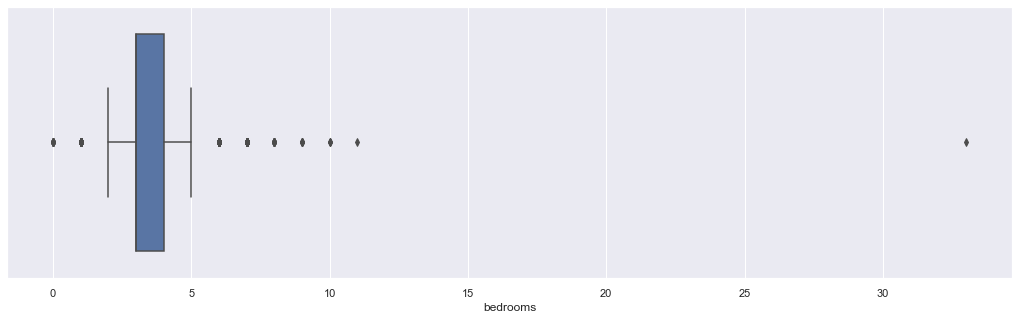

In [149]:
sns.set(rc={'figure.figsize':(18,5)})
sns.boxplot(df4['bedrooms']);

In [151]:
df4[df4['bedrooms'] >= 10]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,price/ft2,median_price/ft2_zipcode,decision,price_suggestion,profit,profitable_purchase,road,house_number,city,county
3519,2402100895,2014-06-25,640000,33,1.75,1620,6000,1.00,0,0,...,106.67,178.73,1,1072380.95,432380.95,high profit,Corliss Avenue North,8028,Seattle,King County
6884,627300145,2014-08-14,1148000,10,5.25,4590,10920,1.00,0,2,...,105.13,95.00,0,1037385.29,-110614.71,prejudice,Southeast 26th Street,17079,Bellevue,King County
7277,1773100755,2014-08-21,520000,11,3.00,3000,4960,2.00,0,0,...,104.84,62.70,0,310992.00,-209008.00,prejudice,Delridge Way Southwest,5055,Seattle,King County
11362,5566100170,2014-10-29,650000,10,2.00,3610,11914,2.00,0,0,...,54.56,67.93,1,809282.49,159282.49,low profit,Southeast 42nd Street,12353,Bellevue,King County
14181,8812401450,2014-12-29,660000,10,3.00,2920,3745,2.00,0,0,...,176.23,163.92,0,613898.35,-46101.65,prejudice,8th Avenue Northeast,4711,Seattle,King County


Considering that price, number of bathrooms and size of built area are incompatible with the number of bedrooms, we will consider this ad as an outlier to be removed.

#### 4.3.1.2 Lot size in square feet

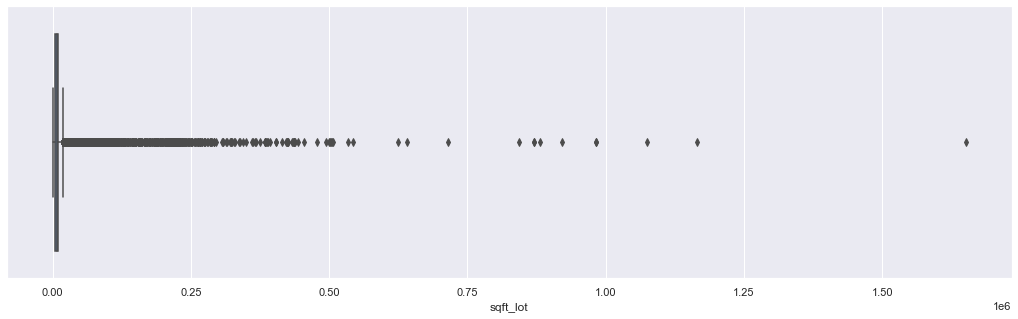

In [152]:
sns.set(rc={'figure.figsize':(18,5)})
sns.boxplot(df4['sqft_lot']);

In [164]:
df4[df4['sqft_lot'] >= 900000.00]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,price/ft2,median_price/ft2_zipcode,decision,price_suggestion,profit,profitable_purchase,road,house_number,city,county
1128,2623069031,2014-05-21,542500,5,3.25,3010,1074218,1.50,0,0,...,0.51,55.39,1,59501592.57,58959092.57,high profit,252nd Avenue Southeast,16206,Issaquah,King County
5898,3626079040,2014-07-30,790000,2,3.00,2560,982278,1.00,0,0,...,0.80,16.17,1,15884992.68,15094992.68,high profit,Northeast Moss Lake Road,w/n,Carnation,King County
8192,722069232,2014-09-05,998000,4,3.25,3770,982998,2.00,0,0,...,1.02,35.83,1,35224095.00,34226095.00,high profit,Southeast 209th Place,19115,Renton,King County
17643,2624089007,2015-03-20,1998000,2,2.50,3900,920423,2.00,0,0,...,2.17,86.19,1,79332410.63,77334410.63,high profit,North Fork Road Southeast,w/n,Snoqualmie,King County
18100,1020069017,2015-03-27,700000,4,1.00,1300,1651359,1.00,0,3,...,0.42,24.44,1,40351123.41,39651123.41,high profit,236th Avenue Southeast,41226,Enumclaw,King County
20757,3326079016,2015-05-04,190000,2,1.00,710,1164794,1.00,0,0,...,0.16,16.17,1,15069252.63,14879252.63,high profit,Kelly Road Northeast,10001,Carnation,King County


We will remove the 3 ads with the biggest sqft_lot

### 4.3.2 Removing Outliers

In [162]:
# removing outliers: beddrooms
df_new = df4[~(df4['bedrooms'] >= 12)]

# removing outliers: Lot size in square feet
df_new = df_new[~(df4['sqft_lot'] >= 1000000.00)]


df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21214 entries, 0 to 21217
Data columns (total 37 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   id                        21214 non-null  int64         
 1   date                      21214 non-null  datetime64[ns]
 2   price                     21214 non-null  int64         
 3   bedrooms                  21214 non-null  int64         
 4   bathrooms                 21214 non-null  float64       
 5   sqft_living               21214 non-null  int64         
 6   sqft_lot                  21214 non-null  int64         
 7   floors                    21214 non-null  float64       
 8   waterfront                21214 non-null  int64         
 9   view                      21214 non-null  int64         
 10  condition                 21214 non-null  int64         
 11  grade                     21214 non-null  int64         
 12  sqft_above        

In [165]:
ratio_of_outliers_removed = 100 - (df_new.shape[0] / df4.shape[0]) * 100
print(f'Ratio of removed outliers: {round(ratio_of_outliers_removed, 2)}%')

Ratio of removed outliers: 0.02%


# 5.0 EXPLORATORY DATA ANALYSIS

In [166]:
df5 = df_new.copy()

In [56]:
df5.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,decision,price_suggestion,profit,profitable_purchase,road,house_number,neighbourhood,city,county,state
16768,5561000190,2014-05-02,437500,3,2.25,1970,35100,2.00,0,0,...,1,1944210.49,1506710.49,high profit,Southeast 154th Street,26069,NaN,Seattle,King County,Washington
9596,472000620,2014-05-02,790000,3,2.50,2600,4750,1.00,0,0,...,0,614705.88,-175294.12,prejudice,34th Avenue Northwest,7506,Sunset Hill,Kent,King County,Washington
9587,1024069009,2014-05-02,675000,5,2.50,2820,67518,2.00,0,0,...,1,7629236.56,6954236.56,high profit,Southeast 32nd Way,23601,NaN,Issaquah,King County,Washington
20602,7853361370,2014-05-02,555000,4,2.50,3310,6500,2.00,0,0,...,1,560243.14,5243.14,low profit,Southeast Terrace Street,35246,NaN,Seattle,King County,Washington
11577,5056500260,2014-05-02,440000,4,2.25,2160,8119,1.00,0,0,...,1,551499.46,111499.46,medium profit,Southeast 65th Street,12201,NaN,Kirkland,King County,Washington


## 5.1 Univariate Analysis

In [58]:
num_attributes = df5.select_dtypes(include = ['int64', 'int32', 'float64'])
cat_attributes = df5.select_dtypes(exclude = ['int64', 'int32', 'float64'])

num_attributes = num_attributes.drop(columns=['waterfront', 'id', 'decision'])
bin_attributes = df5[['waterfront', 'decision']]

### 5.1.1 Response Variable

<AxesSubplot:xlabel='price'>

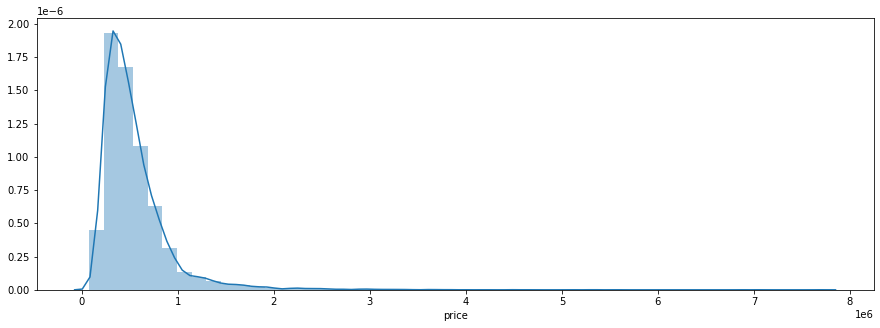

In [59]:
plt.figure(figsize = (15, 5))
sns.distplot(df5['price'])

### 5.1.2 Numerical Variable

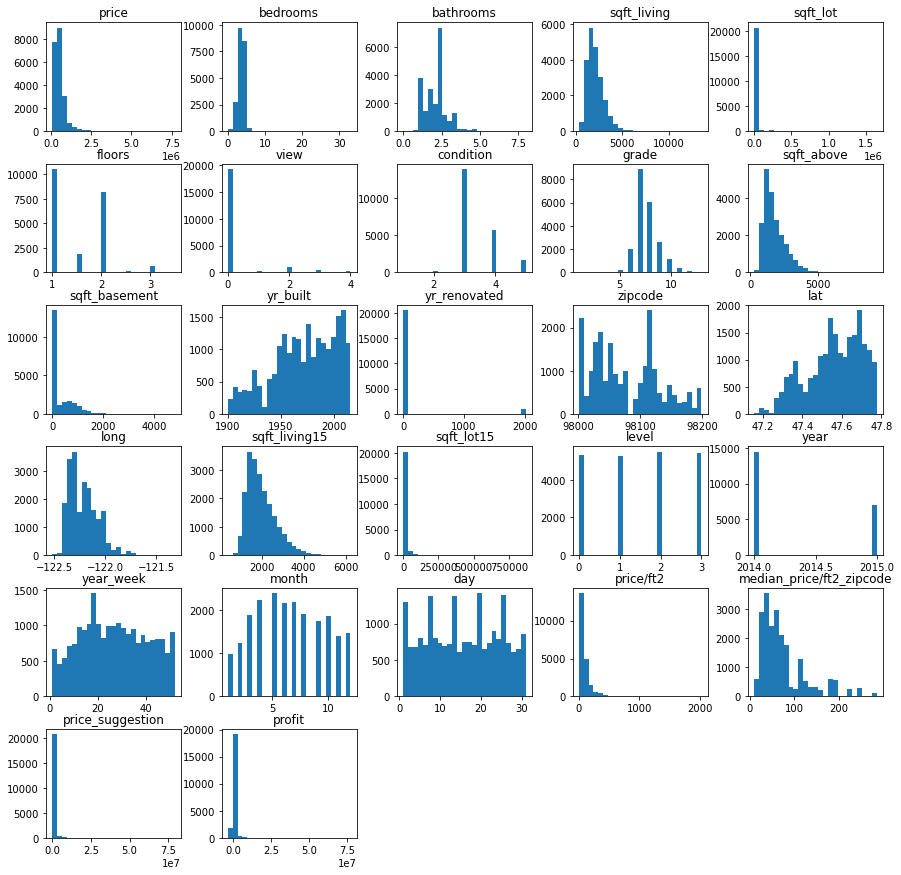

In [60]:
fig = plt.figure(figsize = (15,15))
num_attributes.hist(bins = 25, ax = fig.gca(), grid = False);

In [61]:
descriptive_statistics(num_attributes)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,price,75000.00,7700000.00,7625000.00,541649.96,450000.00,367306.36,4.04,34.73
1,bedrooms,0.00,33.00,33.00,3.37,3.00,0.93,1.99,49.64
2,bathrooms,0.00,8.00,8.00,2.12,2.25,0.77,0.51,1.29
3,sqft_living,290.00,13540.00,13250.00,2082.70,1920.00,919.13,1.47,5.25
4,sqft_lot,520.00,1651359.00,1650839.00,15135.64,7614.00,41537.65,13.04,284.08
5,floors,1.00,3.50,2.50,1.50,1.50,0.54,0.61,-0.49
6,view,0.00,4.00,4.00,0.24,0.00,0.77,3.39,10.83
7,condition,1.00,5.00,4.00,3.41,3.00,0.65,1.04,0.52
8,grade,1.00,13.00,12.00,7.66,7.00,1.17,0.77,1.19
9,sqft_above,290.00,9410.00,9120.00,1790.96,1560.00,829.01,1.44,3.40


### 5.1.3 Categorical Variable

In [62]:
aux1 = df5[['standard', 'road','neighbourhood', 'city', 'county', 'state', 'year_week', 'date']]
countPlotter(aux1)

Generating Count Plots:   0%|          | 0/8 [00:00<?, ?it/s]

ValueError: num must be 1 <= num <= 8, not 0

<Figure size 1440x1440 with 0 Axes>

### 5.1.4 Binary Variable

<AxesSubplot:xlabel='waterfront', ylabel='count'>

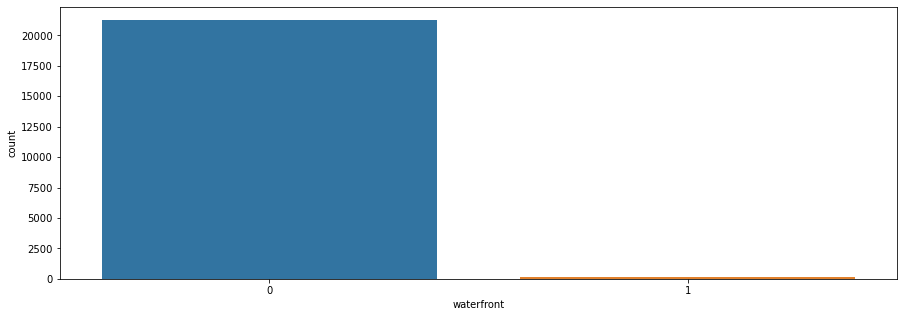

In [63]:
plt.figure(figsize = (15, 5))
sns.countplot(x='waterfront', data = df5)

<AxesSubplot:xlabel='decision', ylabel='count'>

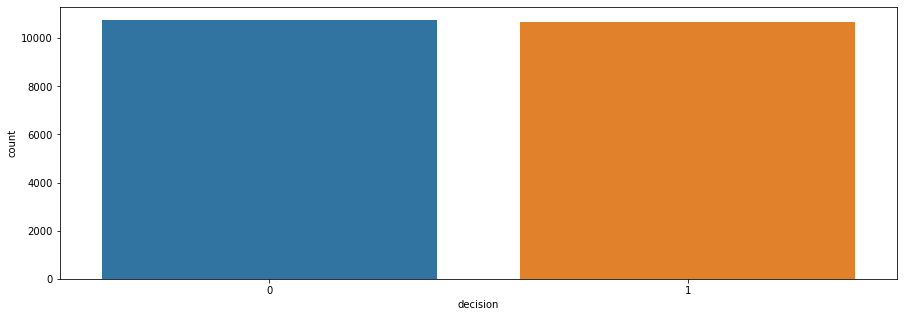

In [65]:
plt.figure(figsize = (15, 5))
sns.countplot(x='decision', data = df5)

## 5.2 Bivariate Analysis

In [67]:
df5.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'standard', 'level',
       'year', 'year_week', 'month', 'day', 'price/ft2',
       'median_price/ft2_zipcode', 'decision', 'price_suggestion', 'profit',
       'profitable_purchase', 'road', 'house_number', 'neighbourhood', 'city',
       'county', 'state'],
      dtype='object')

Generating Group Plots:   0%|          | 0/16 [00:00<?, ?it/s]

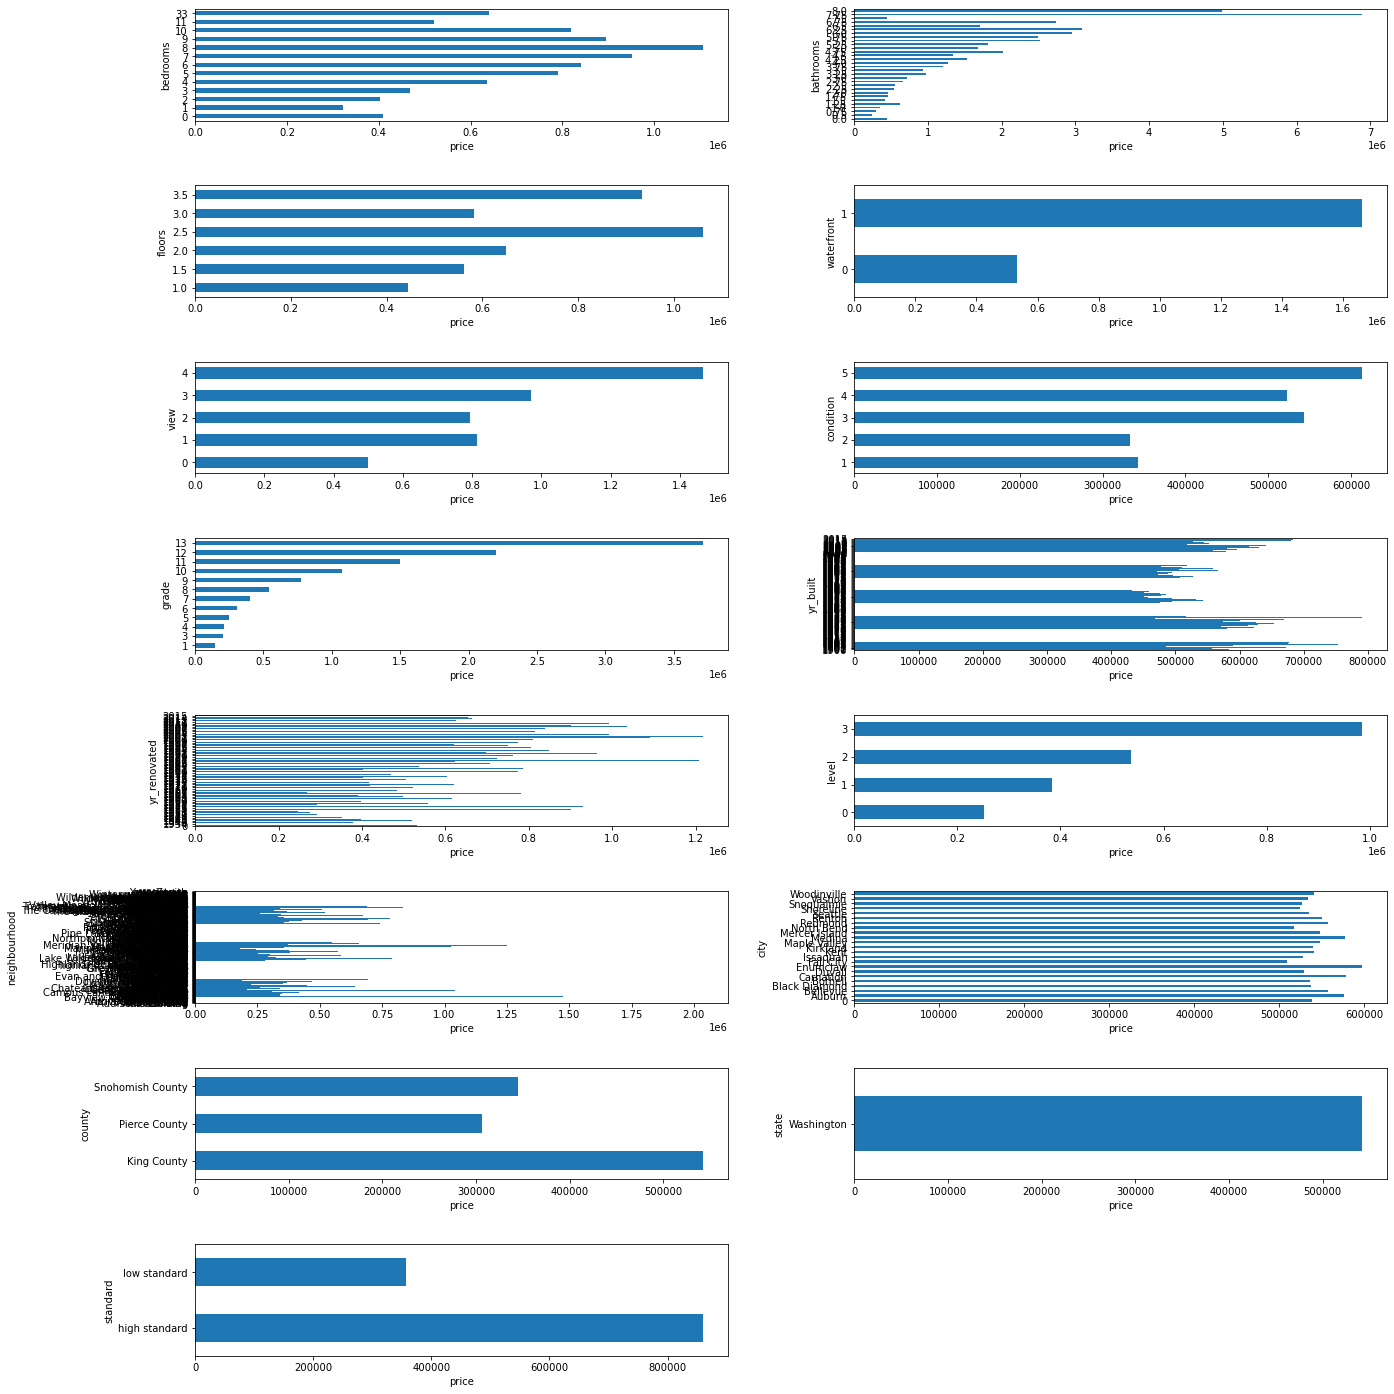

In [68]:
aux2 = df5[['price','bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade',
           'yr_built', 'yr_renovated', 'level','neighbourhood', 'city', 'county', 'state', 'standard']]

barPlotter(aux2)

## 5.3 Multivariate Analysis

### 5.3.1 Numerical Attributes

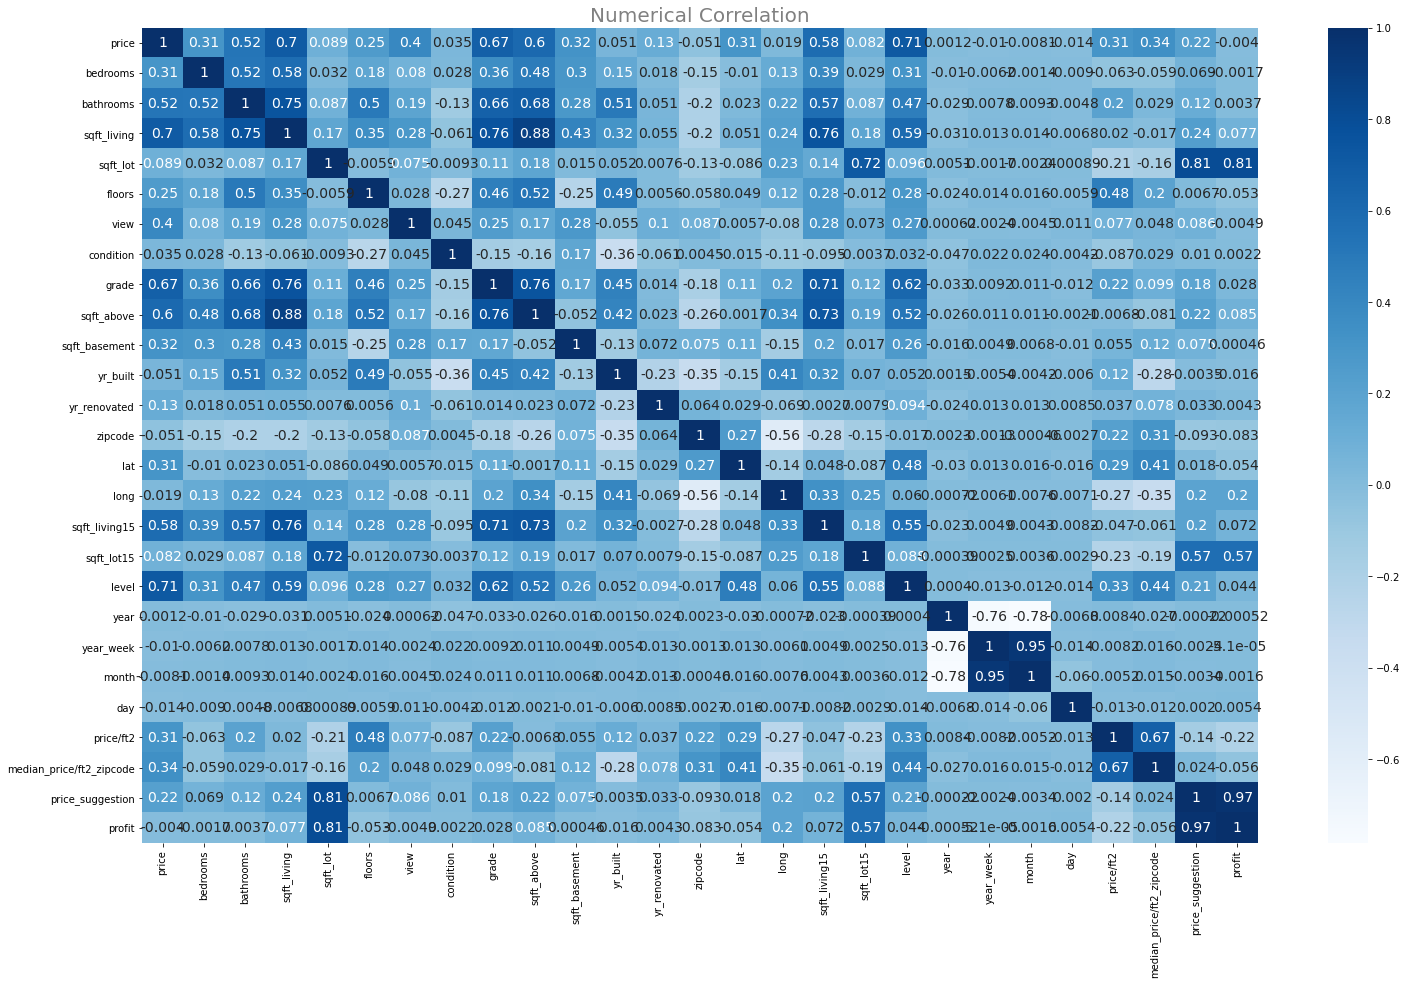

In [69]:
fig = plt.figure(figsize = (25,15))
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation, annot = True, annot_kws={"fontsize":14}, cmap="Blues");
plt.title("Numerical Correlation", size=20, color='gray');

### 5.3.2 Binary x Numerical Attributes

In [70]:
num_attributes.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built',
       'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
       'level', 'year', 'year_week', 'month', 'day', 'price/ft2',
       'median_price/ft2_zipcode', 'price_suggestion', 'profit'],
      dtype='object')

In [71]:
x1 = pointbiserialr(bin_attributes, num_attributes['price'])[0]
x2 = pointbiserialr(bin_attributes, num_attributes['bedrooms'])[0]
x3 = pointbiserialr(bin_attributes, num_attributes['bathrooms'])[0]
x4 = pointbiserialr(bin_attributes, num_attributes['sqft_living'])[0]
x5 = pointbiserialr(bin_attributes, num_attributes['sqft_lot'])[0]
x6 = pointbiserialr(bin_attributes, num_attributes['floors'])[0]
x7 = pointbiserialr(bin_attributes, num_attributes['view'])[0]
x8 = pointbiserialr(bin_attributes, num_attributes['condition'])[0]
x9 = pointbiserialr(bin_attributes, num_attributes['grade'])[0]
x10 = pointbiserialr(bin_attributes, num_attributes['sqft_above'])[0]
x11 = pointbiserialr(bin_attributes, num_attributes['sqft_basement'])[0]
x12 = pointbiserialr(bin_attributes, num_attributes['yr_built'])[0]
x13 = pointbiserialr(bin_attributes, num_attributes['yr_renovated'])[0]
x14 = pointbiserialr(bin_attributes, num_attributes['zipcode'])[0]
x15 = pointbiserialr(bin_attributes, num_attributes['lat'])[0]
x16 = pointbiserialr(bin_attributes, num_attributes['long'])[0]
x17 = pointbiserialr(bin_attributes, num_attributes['sqft_living15'])[0]
x18 = pointbiserialr(bin_attributes, num_attributes['sqft_lot15'])[0]
x19 = pointbiserialr(bin_attributes, num_attributes['level'])[0]
x20 = pointbiserialr(bin_attributes, num_attributes['year'])[0]
x21 = pointbiserialr(bin_attributes, num_attributes['year_week'])[0]
x22 = pointbiserialr(bin_attributes, num_attributes['month'])[0]
x23 = pointbiserialr(bin_attributes, num_attributes['day'])[0]
x24 = pointbiserialr(bin_attributes, num_attributes['day'])[0]
x25 = pointbiserialr(bin_attributes, num_attributes['day'])[0]
x26 = pointbiserialr(bin_attributes, num_attributes['day'])[0]

# Final dataset
d = pd.DataFrame({'waterfront':[x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13, 
                                x14, x15, x16, x17, x18, x19, x20, x21, x22, x23]})

# Sets the index equal to columns
d = d.set_index(num_attributes.columns)

fig = plt.figure(figsize = (25,10))
sns.heatmap(d, annot = True, annot_kws={"fontsize":14}, cmap="Blues");
plt.title("Point Biserial Correlation", size=20, color='gray');

ValueError: shapes (21436,2) and (21436,) not aligned: 2 (dim 1) != 21436 (dim 0)

### 5.3.3 Categorical Attributes

In [ ]:
# Only categorical data
a = df5.select_dtypes( include = 'object')

In [ ]:
a.columns

In [ ]:
# Calculate cramer v

a1 = cramer_v( a['standard'], a['standard'] )
a2 = cramer_v( a['standard'], a['road'] )
a3 = cramer_v( a['standard'], a['house_number'] )
a4 = cramer_v( a['standard'], a['neighbourhood'] )
a5 = cramer_v( a['standard'], a['city'] )
a6 = cramer_v( a['standard'], a['county'] )
a7 = cramer_v( a['standard'], a['state'] )


a8 = cramer_v( a['road'], a['standard'] )
a9 = cramer_v( a['road'], a['road'] )
a10 = cramer_v( a['road'], a['house_number'] )
a11 = cramer_v( a['road'], a['neighbourhood'] )
a12 = cramer_v( a['road'], a['city'] )
a13 = cramer_v( a['road'], a['county'] )
a14 = cramer_v( a['road'], a['state'] )

a15 = cramer_v( a['house_number'], a['standard'] )
a16 = cramer_v( a['house_number'], a['road'] )
a17 = cramer_v( a['house_number'], a['house_number'] )
a18 = cramer_v( a['house_number'], a['neighbourhood'] )
a19 = cramer_v( a['house_number'], a['city'] )
a20 = cramer_v( a['house_number'], a['county'] )
a21 = cramer_v( a['house_number'], a['state'] )

a22 = cramer_v( a['neighbourhood'], a['standard'] )
a23 = cramer_v( a['neighbourhood'], a['road'] )
a24 = cramer_v( a['neighbourhood'], a['house_number'] )
a25 = cramer_v( a['neighbourhood'], a['neighbourhood'] )
a26 = cramer_v( a['neighbourhood'], a['city'] )
a27 = cramer_v( a['neighbourhood'], a['county'] )
a28 = cramer_v( a['neighbourhood'], a['state'] )

a29 = cramer_v( a['city'], a['standard'] )
a30 = cramer_v( a['city'], a['road'] )
a31 = cramer_v( a['city'], a['house_number'] )
a32 = cramer_v( a['city'], a['neighbourhood'] )
a33 = cramer_v( a['city'], a['city'] )
a34 = cramer_v( a['city'], a['county'] )
a35 = cramer_v( a['city'], a['state'] )

a36 = cramer_v( a['county'], a['standard'] )
a37 = cramer_v( a['county'], a['road'] )
a38 = cramer_v( a['county'], a['house_number'] )
a39 = cramer_v( a['county'], a['neighbourhood'] )
a40 = cramer_v( a['county'], a['city'] )
a41 = cramer_v( a['county'], a['county'] )
a42 = cramer_v( a['county'], a['state'] )

a43 = cramer_v( a['state'], a['standard'] )
a44 = cramer_v( a['state'], a['road'] )
a45 = cramer_v( a['state'], a['house_number'] )
a46 = cramer_v( a['state'], a['neighbourhood'] )
a47 = cramer_v( a['state'], a['city'] )
a48 = cramer_v( a['state'], a['county'] )
a49 = cramer_v( a['state'], a['state'] )

# Final dataset
d = pd.DataFrame( {'standard': [a1, a2, a3, a4, a5, a6, a7],
                   'road': [a8, a9, a10, a11, a12, a13, a14],
                   'house_number': [a15, a16, a17, a18, a19, a20, a21],
                   'neighbourhood': [a22, a23, a24, a25, a26, a27, a28],
                   'city': [a29, a30, a31, a32, a33, a34, a35],
                   'county': [a36, a37, a38, a39, a40, a41, a42],
                   'state': [a43, a44, a45, a46, a47, a48, a49]})

    
d = d.set_index(d.columns)

fig = plt.figure(figsize = (25,10))
sns.heatmap(d, annot = True, annot_kws={"fontsize":14}, cmap="Blues");
plt.title("Categorical Correlation", size=20, color='gray');

# 6.0 MAP

In [ ]:
houses = data[['id', 'lat', 'long', 'price', 'level']].copy()

fig = px.scatter_mapbox(houses, lat ='lat', lon = 'long', color ='level', size = 'price', 
                        color_continuous_scale = px.colors.cyclical.IceFire,
                        size_max = 15, zoom = 10)
fig.update_layout( mapbox_style = 'open-street-map')
fig.update_layout( height = 600, margin = {'r':0, 't':0, 'l':0, 'b':0})
fig.show()

### 6.1 Adding filter options so the person can do their own analysis:
- Filter properties with a water view or not.
- Filter properties down to a certain price value.

In [ ]:
df6 = df5.copy()

In [ ]:
style = {'description_width': 'initial'}

# Iterative buttons
price_limit = widgets.IntSlider( value = 540000, min = 75000, max = 77000000, step = 1,
                                 description = 'Maximum Price', disable = False, style = style)  

df6['is_waterfront'] = df6['waterfront'].apply( lambda x: 'yes' if x == 1 else 'no')

waterfront_bar = widgets.Dropdown(options = df6['is_waterfront'].unique().tolist(),
                                  value = 'yes', description = 'Water View', disable = False)


In [ ]:
widgets.interactive(update_map, df6 = fixed(df6), waterfront = waterfront_bar, limit = price_limit)

# 7.0 DASHBOARD

In [ ]:
import ipywidgets as widgets
from matplotlib import gridspec
from matplotlib import pyplot as plt

In [ ]:
df7 = df6.copy()

In [ ]:
# prepare dataset
#data = pd.read_csv( 'kc_house_data.csv' )

# change date format
#data['year'] = pd.to_datetime( data['date'] ).dt.strftime( '%Y' )
#data['date'] = pd.to_datetime( data['date'] ).dt.strftime( '%Y-%m-%d' )
df7['year_week'] = pd.to_datetime( df7['date'] ).dt.strftime( '%Y-%U' )

# Widgets to control data
date_limit = widgets.SelectionSlider(
             options= df7['date'].sort_values().unique().tolist(),
             value = '2014-12-01',
             description = 'Disponivel',
             continuous_update=False,
             orientation='horizontal',
             readout=True )



In [ ]:
widgets.interactive( new_map, df7 = fixed( df7 ), limit = date_limit)


In [ ]:
fig = plt.figure(figsize=(20, 20))

for i in tqdm_notebook(range(len(df7.columns)), desc = 'Generating Frequency Plots'):
    fig.add_subplot(np.ceil(len(df7.columns)/5), 5, i+1)
    data.iloc[:, i].hist(bins=20)
    plt.title(df7.columns[i])
    fig.tight_layout(pad=3.0)
plt.show();

In [ ]:
df7.head()